In [31]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [32]:
x_1 = np.linspace(-1,1,256)
x_2 = np.linspace(1,-1,256)

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [33]:
X_v_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

usol = -1/(2 * np.pi) * np.log(X**2 + Y**2) + np.cos(np.pi*X) + np.cos(np.pi*Y)
vsol = np.cos(np.pi*X) + np.cos(np.pi*Y)

v_true = vsol.flatten('F')[:,None] 

# Training Data

In [34]:
def trainingdata(N_v,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_v = vsol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_v = vsol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_v = vsol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_v = vsol[-1,:][:,None]
    
    all_X_v_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_v_train = np.vstack([leftedge_v, rightedge_v, bottomedge_v, topedge_v])  
     
    #choose random N_v points for training
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False) 
    
    X_v_train = all_X_v_train[idx[0:N_v], :] #choose indices from  set 'idx' (x,t)
    v_train = all_v_train[idx[0:N_v],:]      #choose corresponding v
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f)
    X_f_train = np.vstack((X_f, X_v_train)) # append training points to collocation points 
    
    return X_f_train, X_v_train, v_train 

# SSDRM

Creating sequential layers using the class
tf.Module

In [35]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_v = self.loss_function(self.forward(x), y)
                
        return loss_v
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        v = self.forward(g)
                
        v_x = autograd.grad(v,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                                            
        v_x_1 = v_x[:,[0]]
        
        v_x_2 = v_x[:,[1]]
                        
        k = 1
        F = np.pi**2*(np.cos(np.pi*x_1_f) + np.cos(np.pi*x_2_f))
        
        f = 1/2 * k * (v_x_1**2 + v_x_2**2) - F * v

        loss_f = torch.mean(f)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_v = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)

        loss = loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train)
        
        error_vec, _ = SSDRM.test()
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((v-v_pred),2)/torch.linalg.norm(v,2)        # Relative L2 Norm of the error (Vector)
        
        v_pred = np.reshape(v_pred.cpu().detach().numpy(),(256,256),order='F') 
        
        return error_vec, v_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: error of 1 boundary point loss
    loss_PDE: variational functional for the PDE


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)
Training time: 13.01
Test Error: 0.03177


C:\Users\HP\AppData\Local\Temp/ipykernel_8744/3196557189.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, usol, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_8744/3196557189.py:62: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, u_pred, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_8744/3196557189.py:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is depreca

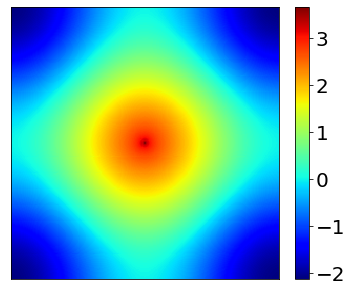

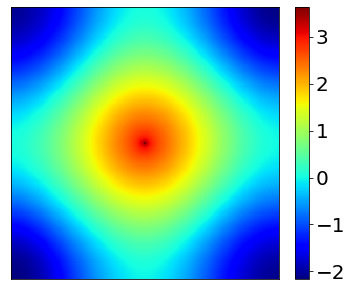

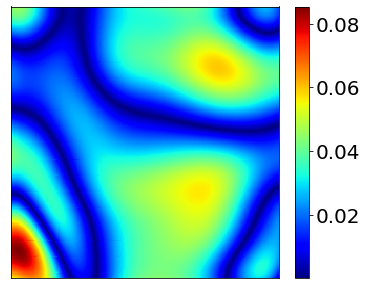

In [36]:
N_v = 1
N_f = 10000 

X_f_train_np_array, X_v_train_np_array, v_train_np_array = trainingdata(N_v,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
v_train = torch.from_numpy(v_train_np_array).float().to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)

layers = np.array([2, 8, 8, 1])

SSDRM = Sequentialmodel(layers)
       
SSDRM.to(device)

'Neural Network Summary'

print(SSDRM)
params = list(SSDRM.parameters())

start_time = time.time()

optimizer = torch.optim.LBFGS(SSDRM.parameters(), lr=0.1, 
                                  max_iter = 1000, 
                                  max_eval = 2500, 
                                  tolerance_grad = 1e-06, 
                                  tolerance_change = 1e-09, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')

optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
optimizer.step(SSDRM.closure)
error_vec, _ = SSDRM.test()
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, v_pred = SSDRM.test()

print('Test Error: %.5f'  % (error_vec))

u_pred = -1/(2*np.pi)*np.log(X**2 + Y**2) + v_pred


# Plotting
#Ground truth
fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(x_1, x_2, usol, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true3.2.png',bbox_inches='tight')

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(x_1, x_2, u_pred, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred3.2.png',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(x_1, x_2, np.abs(usol - u_pred), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('error3.2.png',bbox_inches='tight')
plt.show()